# Building chatbot with Langgraph (Graph api)

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


In [3]:
class State(TypedDict):
    messages: Annotated[list,add_messages]

graph_builder=StateGraph(State)


In [4]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq (model='llama3-8b-8192')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10680e190>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x106a4a510>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state['messages'])]}

In [7]:
graph_builder = StateGraph(State)

graph_builder.add_node("llmagent", chatbot)

graph_builder.add_edge(START, "llmagent")
graph_builder.add_edge("llmagent", END)

graph = graph_builder.compile()



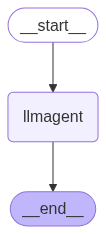

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [9]:
response = graph.invoke({"messages": ["Hello!"]})
response["messages"][-1].content

"Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?"

## Adding Tools

In [10]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2)
tool.invoke("what is langgraph?")


{'query': 'what is langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactio

In [11]:
def multiply(a: int, b: int) -> int:
    """Multiply two numbers
    
    Args:
        a (int): The first number
        b (int): The second number
        
    Returns:
        int: The product of the two numbers
    """
    return a * b



In [12]:
tools = [tool, multiply]
tools


[TavilySearch(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None)),
 <function __main__.multiply(a: int, b: int) -> int>]

In [13]:
llm_tools = llm.bind_tools(tools)
llm_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10680e190>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x106a4a510>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to 

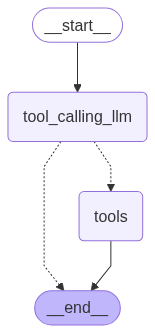

In [14]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition 

def tool_calling_llm(state:State):
    return {"messages": [llm_tools.invoke(state['messages'])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
response = graph.invoke({"messages": ["What is the recent ai news?"]})


In [16]:
response["messages"][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.reuters.com/world/us/americans-fear-ai-permanently-displacing-workers-reutersipsos-poll-finds-2025-08-19/", "title": "Americans fear AI permanently displacing workers, Reuters/Ipsos poll finds - Reuters", "score": 0.6821721, "published_date": "Tue, 19 Aug 2025 10:34:37 GMT", "content": "Technology leaders attend a generative AI (Artificial Intelligence) meeting in San Francisco, in California, U.S., June 29, 2023. REUTERS/Carlos Barria/File Photo Purchase Licensing Rights, opens new tab\\n\\n   Summary\\n   Companies\\n\\n   Seventy-one percent fear AI causing permanent job loss, Reuters/Ipsos poll shows\\n   Seventy-seven percent worry AI could be used by rivals to incite political chaos, poll indicates\\n   Forty-eight percent oppose AI in military targeting, 24% support it [...] The new technology burst into the national conversation in late 2022 when OpenAI\'s Ch

In [17]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (1x03d67sp)
 Call ID: 1x03d67sp
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.reuters.com/world/us/americans-fear-ai-permanently-displacing-workers-reutersipsos-poll-finds-2025-08-19/", "title": "Americans fear AI permanently displacing workers, Reuters/Ipsos poll finds - Reuters", "score": 0.6821721, "published_date": "Tue, 19 Aug 2025 10:34:37 GMT", "content": "Technology leaders attend a generative AI (Artificial Intelligence) meeting in San Francisco, in California, U.S., June 29, 2023. REUTERS/Carlos Barria/File Photo

In [18]:
response=graph.invoke({"messages": "what is 12 multiply 3 and add 6 to it"})

for m in response["messages"]:
    m.pretty_print()


================================ Human Message =================================

what is 12 multiply 3 and add 6 to it
================================== Ai Message ==================================
Tool Calls:
  multiply (y1ragxn0c)
 Call ID: y1ragxn0c
  Args:
    a: 12
    b: 3
================================= Tool Message =================================
Name: multiply

36


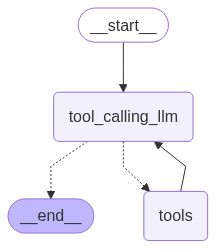

In [19]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition 

def tool_calling_llm(state:State):
    return {"messages": [llm_tools.invoke(state['messages'])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## Adding Memory


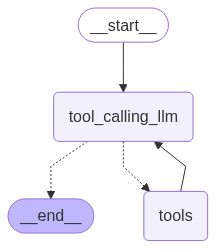

In [28]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory= MemorySaver()


def tool_calling_llm(state:State):
    return {"messages": [llm_tools.invoke(state['messages'])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools","tool_calling_llm")

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
config = {"configurable":{"thread_id":"1"}}

response = graph.invoke({"messages":"I have a labrador retriever named onyx"},config=config)

response["messages"][-1].content

          

"I think I've got a good idea about your furry friend!"

In [37]:
response = graph.invoke({"messages":"What pet do i have"},config=config)

response["messages"][-1].content

'You have a Labrador Retriever named Onyx.'